In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('./UCI_Credit_Card.csv')

Text(0.5, 1.0, '信用卡违约率客户\n(违约1，守约0)')

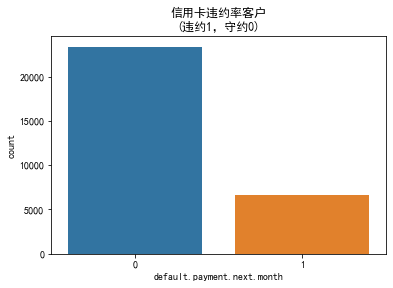

In [33]:
sns.countplot(data['default.payment.next.month'])
plt.title('信用卡违约率客户\n(违约1，守约0)')

In [15]:
data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [16]:
data.drop(['ID'], axis=1, inplace=True)
print(data.info())
print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6                     30000 non-null float64
PAY_AMT1  

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [20]:
cat_columns = ['SEX','EDUCATION', 'MARRIAGE']
numeric_columns = [ col  for col in data.columns if col not in cat_columns+['default.payment.next.month']]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(data[cat_columns+numeric_columns], data['default.payment.next.month'], test_size=0.2)

In [57]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

features = FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric_columns),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=cat_columns),OneHotEncoder(sparse=False)))
        ])

In [83]:
classifiers = {
    'SVC':SVC(),
    'DecisionTree':DecisionTreeClassifier(),
    'RandomForsrt':RandomForestClassifier(),
    'KNN':KNeighborsClassifier(),
    'XGB':XGBClassifier(),
    'LGBMClassifier':LGBMClassifier()    
}
classifier_param_grid = [
            {'SVC__C':[1], 'SVC__gamma':[0.01]},
            {'DecisionTree__max_depth':[6,9,11]},
            {'RandomForsrt__n_estimators':[3,5,6,50]} ,
            {'KNN__n_neighbors':[4,6,8]},
            {'XGB__n_estimators':[3,5,6,10], 'XGB__scale_pos_weight':[1.0,3.0]},
            {'LGBMClassifier__n_estimators':[3,5,6,100],'LGBMClassifier__class_weight':['balanced'],'LGBMClassifier__reg_alpha':[0.0,0.1,0.2],'LGBMClassifier__reg_lambda':[0.0,0.1,0.2]},
]

def GridSearchCV_work(pipeline, X_train, y_train, X_test, y_test, model_param_grid , score = 'accuracy'):
    clf = GridSearchCV(estimator=pipeline, param_grid=model_param_grid, scoring=score)
    search = clf.fit(X_train, y_train)
    print('GridSearch最优参数:',search.best_params_)
    print('GridSearch最优分数:%0.4lf' %search.best_score_)
    y_predict = clf.predict(X_test)
    print('准确率：%0.4lf' %accuracy_score(y_predict, y_test))
    response = {}
    response['y_predict'] = y_predict
    response['accuracy_score'] = accuracy_score(y_predict, y_test)
    return response

for model, model_name, model_param_grid in zip(classifiers.values(), classifiers.keys(), classifier_param_grid):
    pipeline = Pipeline([
        ("features", features),                          
        (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, X_train, y_train, X_test, y_test, model_param_grid , score = 'accuracy')
    

GridSearch最优参数: {'SVC__C': 1, 'SVC__gamma': 0.01}
GridSearch最优分数:0.8183
准确率：0.8152
GridSearch最优参数: {'DecisionTree__max_depth': 6}
GridSearch最优分数:0.8186
准确率：0.8158
GridSearch最优参数: {'RandomForsrt__n_estimators': 50}
GridSearch最优分数:0.8154
准确率：0.8142
GridSearch最优参数: {'KNN__n_neighbors': 8}
GridSearch最优分数:0.8045
准确率：0.8042
GridSearch最优参数: {'XGB__n_estimators': 6, 'XGB__scale_pos_weight': 1.0}
GridSearch最优分数:0.8209
准确率：0.8147
GridSearch最优参数: {'LGBMClassifier__class_weight': 'balanced', 'LGBMClassifier__n_estimators': 100, 'LGBMClassifier__reg_alpha': 0.1, 'LGBMClassifier__reg_lambda': 0.0}
GridSearch最优分数:0.7637
准确率：0.7613


In [80]:
LGBMClassifier?

In [81]:
XGBClassifier?